
## Evaluating the performance of a hybrid power plant with P2X using HyDesign

In this notebook we will evaluate a hybrid power plant design in a specific location.

A hybrid power plant design consists on selecting the following parameters:

**Wind Plant design:**

1. Number of wind turbines in the wind plant [-] (`Nwt`)
2. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

3. Solar plant power capacity [MW] (`solar_MW`)

**Battery Storage design:**

4. Battery power [MW] (`b_P`)
5. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
6. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.

**Electrolyzer design:**

7. Electrolyzer capacity [MW] (`ptg_MW`)
8. H2 storage capacity [kg] (`HSS_kg`)

##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [1]:
# # Detect if running in Kaggle
# import os 
# if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
#     mypaths = !python -c "import sysconfig; print(sysconfig.get_paths()['purelib'])"
#     mypath = mypaths[0]
#     !pip install trash-cli
#     !trash $mypath/numpy*
#     !pip install --upgrade numpy
#     !pip install finitediff
#     import os
#     os.kill(os.getpid(), 9)

In [2]:
# # Install hydesign if needed
# import importlib
# if not importlib.util.find_spec("hydesign"):
#     !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [3]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.assembly.hpp_assembly_P2X import hpp_model_P2X as hpp_model
from hydesign.examples import examples_filepath

C:\Users\gupta\AppData\Local\Temp\ipykernel_36408\1618823073.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
examples_sites

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col,H2_demand_col,Unnamed: 11,input_HA_ts_fn,price_up_ts,price_dwn_ts
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/GWA2/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/GWA2/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/GWA2/input_ts_Indian_site_bad_solar_bad_...,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/GWA2/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/GWA2/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/GWA2/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/GWA2/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/GWA2/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/GWA2/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/GWA2/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W,Europe/H2_demand.csv,NaN,NaN,NaN,NaN


##
**Select a site to run**

In [5]:
name = 'Denmark_good_wind'

ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

In [6]:
# Weather data and Price data
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]

input_ts = pd.read_csv(input_ts_fn, index_col=0, parse_dates=True)

required_cols = [col for col in input_ts.columns if 'WD' not in col]
input_ts = input_ts.loc[:,required_cols]
input_ts

,WS_1,WS_50,WS_100,WS_150,WS_200,temp_air_1,ghi,dni,dhi,Price,Unnamed: 16
2012-01-01 00:00:00,2.803428,6.289076,8.109687,8.777118,10.335076,276.767325,0.035121,0.0,0.035121,35.171,NaN
2012-01-01 01:00:00,2.791624,6.275261,8.093319,8.910806,10.407985,277.374423,0.017560,0.0,0.017560,35.171,NaN
2012-01-01 02:00:00,3.036807,6.656427,8.547709,9.467695,10.864995,278.015879,0.000000,0.0,0.000000,35.171,NaN
2012-01-01 03:00:00,3.405581,7.233561,9.237670,10.435093,11.793017,278.655888,0.000000,0.0,0.000000,35.171,NaN
2012-01-01 04:00:00,3.649363,7.542440,9.584774,10.864283,12.081760,279.290819,0.000000,0.0,0.000000,35.171,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-30 19:00:00,3.263756,7.267221,9.358232,10.267748,11.455513,277.214861,0.000000,0.0,0.000000,35.446,NaN
2012-12-30 20:00:00,3.368223,7.417605,9.533621,10.482431,11.694345,276.913527,0.000000,0.0,0.000000,33.565,NaN
2012-12-30 21:00:00,3.392954,7.546295,9.715589,10.655855,11.978293,277.356365,0.000000,0.0,0.000000,32.709,NaN
2012-12-30 22:00:00,3.898207,8.486008,10.884241,11.965626,13.407147,278.369005,0.000000,0.0,0.000000,31.392,NaN


In [7]:
# Hydrogen demand data, when H2 offtake is infinite -> make H2_demand values very high (1e6) in H2_demand.csv file and penalty_H2 as '0' in hpp_pars.yml file
H2_demand_fn = examples_filepath+ex_site['H2_demand_col'].values[0]

H2_demand_ts = pd.read_csv(H2_demand_fn, index_col=0, parse_dates=True)
H2_demand_ts

,H2_demand
2012-01-01 00:00:00,10000
2012-01-01 01:00:00,10000
2012-01-01 02:00:00,10000
2012-01-01 03:00:00,10000
2012-01-01 04:00:00,10000
...,...
2012-12-31 19:00:00,10000
2012-12-31 20:00:00,10000
2012-12-31 21:00:00,10000
2012-12-31 22:00:00,10000


In [8]:
# Input data of technology's cost
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]

with open(sim_pars_fn) as file:
    sim_pars = yaml.load(file, Loader=yaml.FullLoader)

print(sim_pars_fn)    
sim_pars

c:/users/gupta/hydesign/hydesign/examples/Europe/hpp_pars.yml


{'G_MW': 300,
 'year': '2012',
 'N_life': 25,
 'wind_turbine_cost': 640000,
 'wind_civil_works_cost': 260000,
 'wind_fixed_onm_cost': 12600,
 'wind_variable_onm_cost': 1.35,
 'd_ref': 145,
 'hh_ref': 100,
 'p_rated_ref': 5.0,
 'wpp_efficiency': 1,
 'wind_deg_yr': [0, 25],
 'wind_deg': [0, 0.25],
 'share_WT_deg_types': 0.5,
 'solar_PV_cost': 110000,
 'solar_hardware_installation_cost': 100000,
 'solar_inverter_cost': 20000,
 'solar_fixed_onm_cost': 4500,
 'land_use_per_solar_MW': 0.01226,
 'tracking': 'No',
 'pv_deg_yr': [0, 1, 25],
 'pv_deg': [0.03, 0.03, 0.28],
 'battery_energy_cost': 62000,
 'battery_power_cost': 16000,
 'battery_BOP_installation_commissioning_cost': 80000,
 'battery_control_system_cost': 0,
 'battery_energy_onm_cost': 540,
 'battery_depth_of_discharge': 0.9,
 'battery_charge_efficiency': 0.985,
 'battery_price_reduction_per_year': 0.05,
 'min_LoH': 0.7,
 'n_full_power_hours_expected_per_day_at_peak_price': 0,
 'peak_hr_quantile': 0.9,
 'price_H2': 5,
 'storage_eff':

## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [9]:
hpp = hpp_model(
        latitude,
        longitude,
        altitude,
        num_batteries = 3,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
        H2_demand_fn = H2_demand_fn, 
)


Fixed parameters on the site
-------------------------------
longitude = 8.594398
latitude = 56.227322
altitude = 85.0


##
### Evaluating the HPP model

In [10]:
start = time.time()

clearance = 10
sp = 360
p_rated = 4        
Nwt = 90
wind_MW_per_km2 = 5
solar_MW = 80
surface_tilt = 50
surface_azimuth = 210
DC_AC_ratio = 1.5
b_P = 50
b_E_h  = 3
cost_of_batt_degr = 10
ptg_MW = 130
HSS_kg = 0

x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, solar_MW, \
surface_tilt, surface_azimuth, DC_AC_ratio, b_P, b_E_h , cost_of_batt_degr, ptg_MW, HSS_kg]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )


Design:
---------------
clearance [m]: 10.000
sp [W/m2]: 360.000
p_rated [MW]: 4.000
Nwt: 90.000
wind_MW_per_km2 [MW/km2]: 5.000
solar_MW [MW]: 80.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 210.000
DC_AC_ratio: 1.500
b_P [MW]: 50.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000
ptg_MW [MW]: 130.000
HSS_kg [kg]: 0.000


NPV_over_CAPEX: 0.809
NPV [MEuro]: 388.248
IRR: 0.124
LCOE [Euro/MWh]: 45.022
LCOH [Euro/kg]: 8.278
Revenue [MEuro]: 1315.975
CAPEX [MEuro]: 479.644
OPEX [MEuro]: 8.475
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 173.091
GUF: 0.066
annual_H2 [tons]: 9261.560
annual_P_ptg [GWh]: 610.039
grid [MW]: 300.000
wind [MW]: 360.000
solar [MW]: 80.000
PtG [MW]: 130.000
HSS [kg]: 0.000
Battery Energy [MWh]: 150.000
Battery Power [MW]: 50.000
Total curtailment [GWh]: 0.000
Awpp [km2]: 72.000
Apvp [km2]: 0.981
Rotor diam [m]: 118.942
Hub height [m]: 69.471
Number of batteries used in lifetime: 1.000
Break-even H2 price [Euro/kg]: 2.713
Break-even PP

##
### Plot the HPP operation

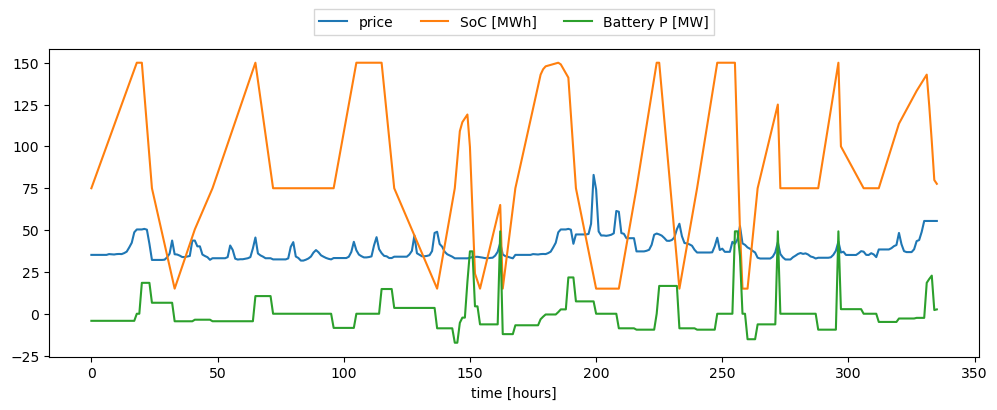

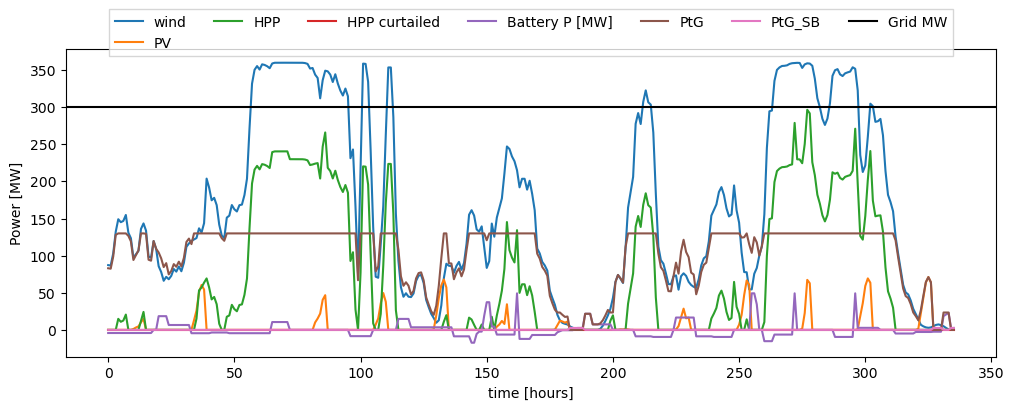

In [11]:
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_t = hpp.prob.get_val('ems.b_t')
price_t = hpp.prob.get_val('ems.price_t')

wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('ems.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
P_ptg_t = hpp.prob.get_val('ems.P_ptg_t')
P_ptg_SB_t = hpp.prob.get_val('ems.P_ptg_SB_t')
grid_MW = hpp.prob.get_val('ems.G_MW')

m_H2_t = hpp.prob.get_val('ems.m_H2_t')
m_H2_demand_t = hpp.prob.get_val('ems.m_H2_demand_t_ext')
m_H2_offtake_t = hpp.prob.get_val('ems.m_H2_offtake_t')
LoS_H2_t = hpp.prob.get_val('ems.LoS_H2_t')

n_days_plot = 14
plt.figure(figsize=[12,4])
plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(wind_t[:24*n_days_plot], label='wind')
plt.plot(solar_t[:24*n_days_plot], label='PV')
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.plot(P_ptg_t[:24*n_days_plot], label='PtG')
plt.plot(P_ptg_SB_t[:24*n_days_plot], label='PtG_SB')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=7, fancybox=0, shadow=0)


In [12]:
results = {'Wind': wind_t, 'PV': solar_t, 'HPP': hpp_t[:8760], 'Curtailment': hpp_curt_t[:8760],\
                    'Battery power': b_t[:8760], 'Energy Level': b_E_SOC_t[:8760], 'Prices': price_t, 'PtG': P_ptg_t[:8760], 'Mass H2': m_H2_t[:8760], 'PtG_SB': P_ptg_SB_t[:8760],}
df = pd.DataFrame(results)
df.to_csv('EMS_out_9_P2X.csv')

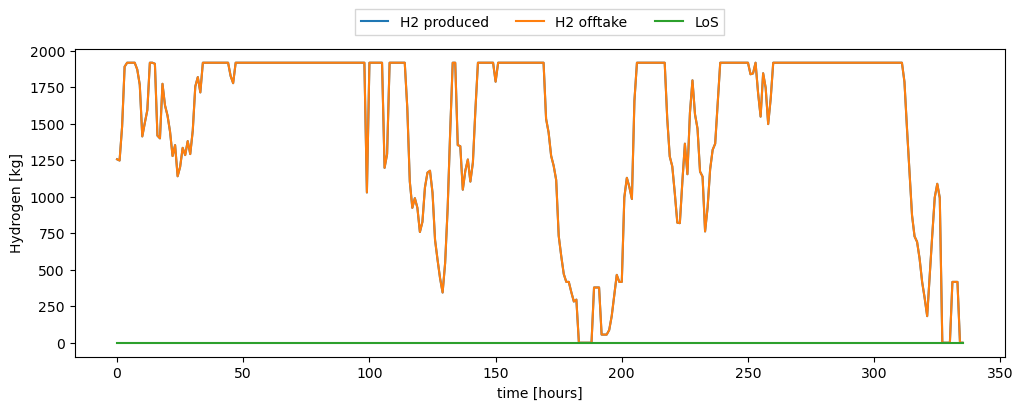

In [13]:

plt.figure(figsize=[12,4])
plt.plot(m_H2_t[:24*n_days_plot], label='H2 produced')
plt.plot(m_H2_offtake_t[:24*n_days_plot], label='H2 offtake')
#plt.plot(m_H2_demand_t[:24*n_days_plot], label='H2 demand')
plt.plot(LoS_H2_t[:24*n_days_plot], label='LoS')
plt.xlabel('time [hours]')
plt.ylabel('Hydrogen [kg]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)